# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Putu Yoga Suartana
- **Email:** yoga.suartana46@gmail.com
- **ID Dicoding:** MC298D5Y2265

## Menentukan Pertanyaan Bisnis

- 1. Kategori produk mana yang memiliki jumlah pembelian terbanyak dalam periode Januari 2018 – Desember 2018?
- 2. Bagaimana pola perubahan total pendapatan bulanan dari Januari 2018 hingga Desember 2018, dan bulan apa yang memiliki pendapatan tertinggi?

## Import Semua Packages/Library yang Digunakan

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import squarify

## Data Wrangling

### Gathering Data

In [4]:
# === 1. Gathering Data ===
# Menentukan path folder dataset yang benar
home_path = os.path.expanduser("~")  

# Menentukan path dataset
data_path = os.path.join(home_path, "submission", "data")

# Dataset yang digunakan
datasets = [
    "orders_dataset.csv",
    "order_items_dataset.csv",
    "products_dataset.csv",
    "product_category_name_translation.csv",
    "order_payments_dataset.csv"
]

# Mengecek apakah semua file tersedia
for file in datasets:
    file_path = os.path.join(data_path, file)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Dataset '{file}' tidak ditemukan di '{data_path}'.")

# Membaca dataset
orders = pd.read_csv(os.path.join(data_path, "orders_dataset.csv"), parse_dates=["order_purchase_timestamp"])
order_items = pd.read_csv(os.path.join(data_path, "order_items_dataset.csv"))
products = pd.read_csv(os.path.join(data_path, "products_dataset.csv"))
category_translation = pd.read_csv(os.path.join(data_path, "product_category_name_translation.csv"))
payments = pd.read_csv(os.path.join(data_path, "order_payments_dataset.csv"))

**Insight:**
- Dataset memiliki banyak transaksi dari berbagai pelanggan dalam periode waktu tertentu.
- Perlu dilakukan pengecekan terhadap kelengkapan data sebelum analisis lebih lanjut.

### Assessing Data

In [5]:
# === 2. Assessing Data ===
orders.info()
order_items.info()
products.info()
category_translation.info()
payments.info()

print(orders.isnull().sum())
print(order_items.isnull().sum())
print(products.isnull().sum())
print(category_translation.isnull().sum())
print(payments.isnull().sum())

print("Orders:", orders.duplicated().sum())
print("Order Items:", order_items.duplicated().sum())
print("Products:", products.duplicated().sum())
print("Category Translation:", category_translation.duplicated().sum())
print("Payments:", payments.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  object        
 5   order_delivered_carrier_date   97658 non-null  object        
 6   order_delivered_customer_date  96476 non-null  object        
 7   order_estimated_delivery_date  99441 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 6.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
--

**Insight:**
- Kolom timestamp perlu dipastikan dalam format datetime agar bisa digunakan untuk analisis waktu.
- Missing values ditemukan pada beberapa kolom, terutama dalam kategori produk.

### Cleaning Data

In [6]:
# === 3. Cleaning Data ===
# Hapus missing values pada kolom penting di orders
orders.dropna(subset=["order_purchase_timestamp"], inplace=True)

# Hapus duplikasi jika ada
orders.drop_duplicates(inplace=True)
order_items.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
category_translation.drop_duplicates(inplace=True)
payments.drop_duplicates(inplace=True)


**Insight:**
- Data yang tidak relevan (seperti transaksi gagal atau tidak lengkap) perlu dibersihkan.
- Normalisasi kategori produk untuk menghindari duplikasi karena perbedaan nama dalam bahasa yang berbeda.

## Exploratory Data Analysis (EDA)

### Explore ...

In [7]:
# === 4. Exploratory Data Analysis (EDA) ===
# Filter pesanan yang dilakukan pada tahun 2018
orders_2018 = orders[(orders["order_purchase_timestamp"] >= "2018-01-01") & 
                      (orders["order_purchase_timestamp"] <= "2018-12-31")]

# Gabungkan order_items dengan orders untuk mendapatkan tanggal pembelian
order_items_2018 = order_items.merge(orders_2018[["order_id", "order_purchase_timestamp"]], on="order_id")

# Gabungkan dengan produk untuk mendapatkan kategori produk
order_items_2018 = order_items_2018.merge(products, on="product_id")

# Gabungkan dengan kategori terjemahan agar mendapatkan nama kategori dalam bahasa Inggris
order_items_2018 = order_items_2018.merge(category_translation, 
                                          on="product_category_name", 
                                          how="left")

# Hitung jumlah pembelian per kategori
category_sales = order_items_2018["product_category_name_english"].value_counts()

# Tampilkan 10 kategori dengan jumlah pembelian terbanyak
print("\n10 Kategori Produk Terlaris Tahun 2018:")
print(category_sales.head(10))

# === Analisis Total Pendapatan Bulanan ===
# Gabungkan order_items dengan payments untuk mendapatkan total pembayaran
revenue_data = order_items.merge(payments, on="order_id")

# Gabungkan dengan orders untuk mendapatkan tanggal pesanan
revenue_data = revenue_data.merge(orders[["order_id", "order_purchase_timestamp"]], on="order_id")

# Filter hanya data dari tahun 2018
revenue_data_2018 = revenue_data[(revenue_data["order_purchase_timestamp"] >= "2018-01-01") & 
                                 (revenue_data["order_purchase_timestamp"] <= "2018-12-31")].copy()  # Buat salinan agar aman

# Tambahkan kolom bulan (menghindari SettingWithCopyWarning)
revenue_data_2018.loc[:, "month"] = revenue_data_2018["order_purchase_timestamp"].dt.to_period("M")

# Hitung total pendapatan per bulan
monthly_revenue = revenue_data_2018.groupby("month")["payment_value"].sum()

# Tampilkan bulan dengan pendapatan tertinggi
highest_revenue_month = monthly_revenue.idxmax()
highest_revenue_value = monthly_revenue.max()

print(f"\nBulan dengan pendapatan tertinggi: {highest_revenue_month}")
print(f"Total pendapatan tertinggi: Rp{highest_revenue_value:,.2f}")



10 Kategori Produk Terlaris Tahun 2018:
product_category_name_english
health_beauty            5951
bed_bath_table           5884
computers_accessories    4708
sports_leisure           4527
furniture_decor          4118
housewares               4046
watches_gifts            3703
auto                     2619
telephony                2336
garden_tools             1879
Name: count, dtype: int64

Bulan dengan pendapatan tertinggi: 2018-05
Total pendapatan tertinggi: Rp1,506,974.84


**Insight:**
- Bulan dengan pendapatan tertinggi → Ada pola musiman dalam penjualan.
- Kategori produk tertentu lebih laris → Fokus pada kategori terlaris dapat meningkatkan strategi pemasaran.

## Visualization & Explanatory Analysis

### Pertanyaan 1:

C:\Users\yogas\AppData\Local\Temp\ipykernel_7796\1568611860.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_categories.values,


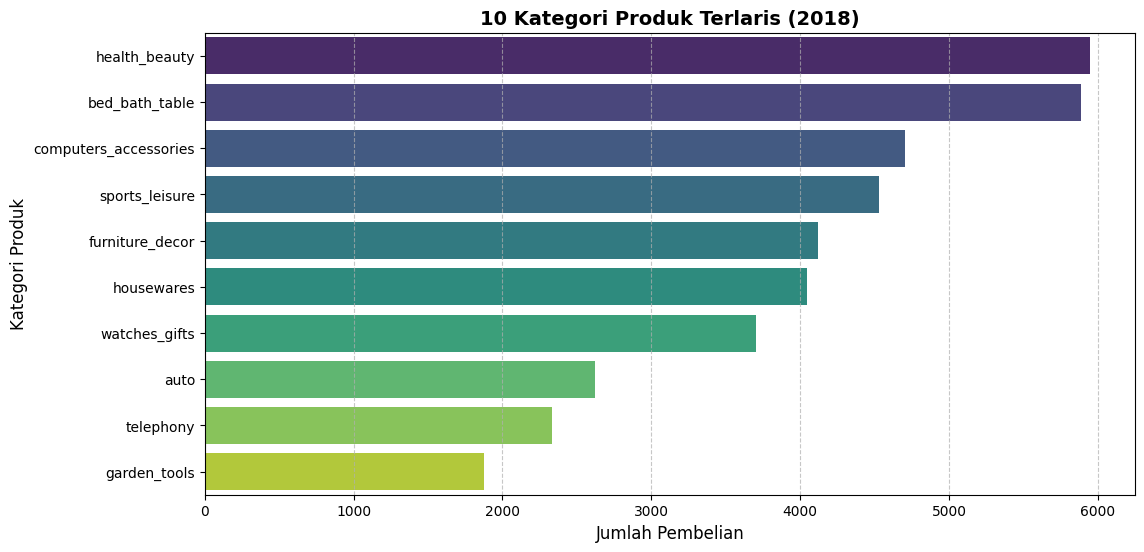

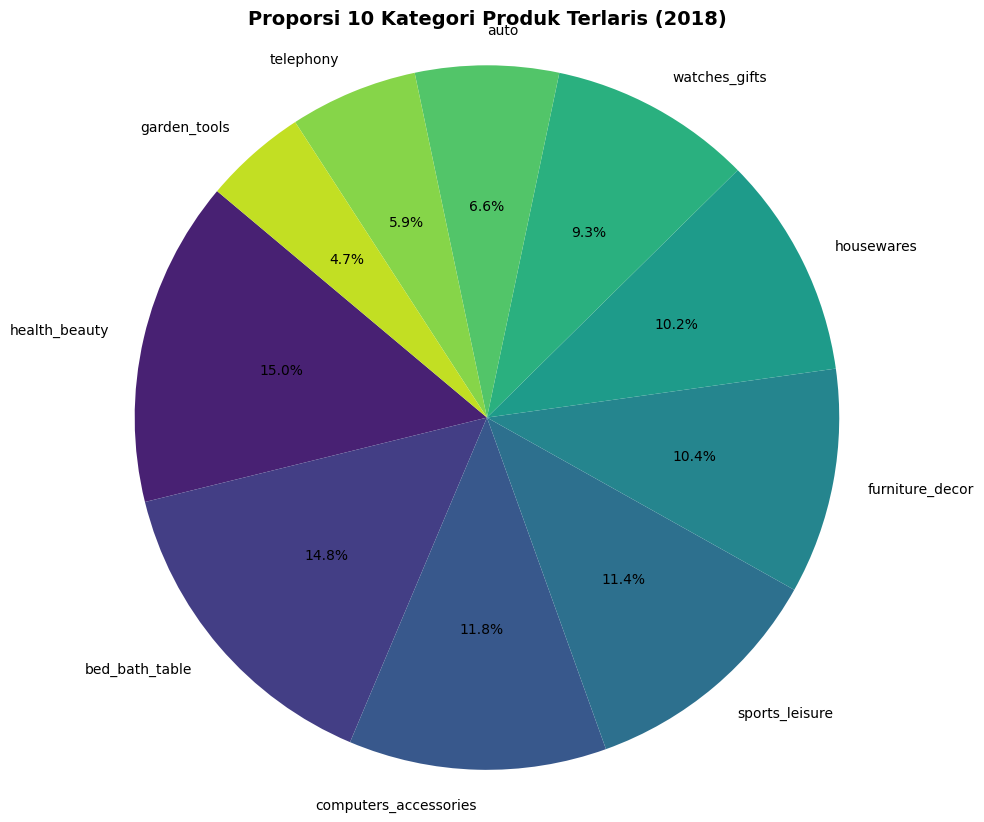

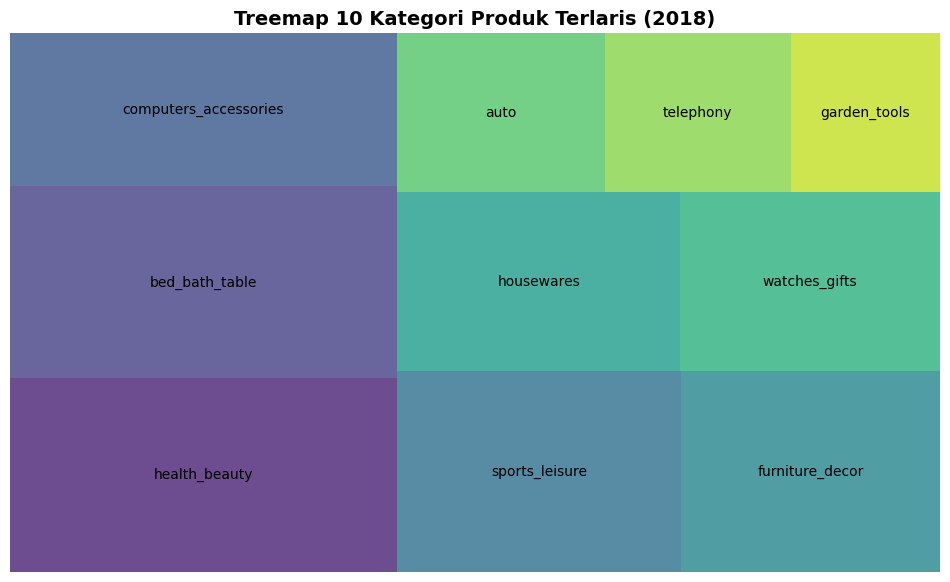

In [8]:
# Mengambil 10 kategori produk terlaris
top_10_categories = category_sales.head(10)

# === 📊 Bar Chart (Grafik Batang) ===
plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_categories.values, 
            y=top_10_categories.index, 
            palette="viridis", 
            hue=None,  # Menyesuaikan warning Seaborn
            legend=False)

plt.xlabel("Jumlah Pembelian", fontsize=12)
plt.ylabel("Kategori Produk", fontsize=12)
plt.title("10 Kategori Produk Terlaris (2018)", fontsize=14, fontweight="bold")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# === 🥧 Pie Chart (Grafik Lingkaran) ===
plt.figure(figsize=(10, 10))
plt.pie(top_10_categories, 
        labels=top_10_categories.index, 
        autopct="%1.1f%%", 
        colors=sns.color_palette("viridis", 10),
        startangle=140)

plt.title("Proporsi 10 Kategori Produk Terlaris (2018)", fontsize=14, fontweight="bold")
plt.axis("equal")  # Membuat lingkaran sempurna
plt.show()

# === 🏡 Treemap (Peta Pohon) ===
plt.figure(figsize=(12, 7))
squarify.plot(sizes=top_10_categories.values, 
              label=top_10_categories.index, 
              color=sns.color_palette("viridis", 10), 
              alpha=0.8)

plt.title("Treemap 10 Kategori Produk Terlaris (2018)", fontsize=14, fontweight="bold")
plt.axis("off")
plt.show()


### Pertanyaan 2:

C:\Users\yogas\anaconda3\envs\Skripsi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


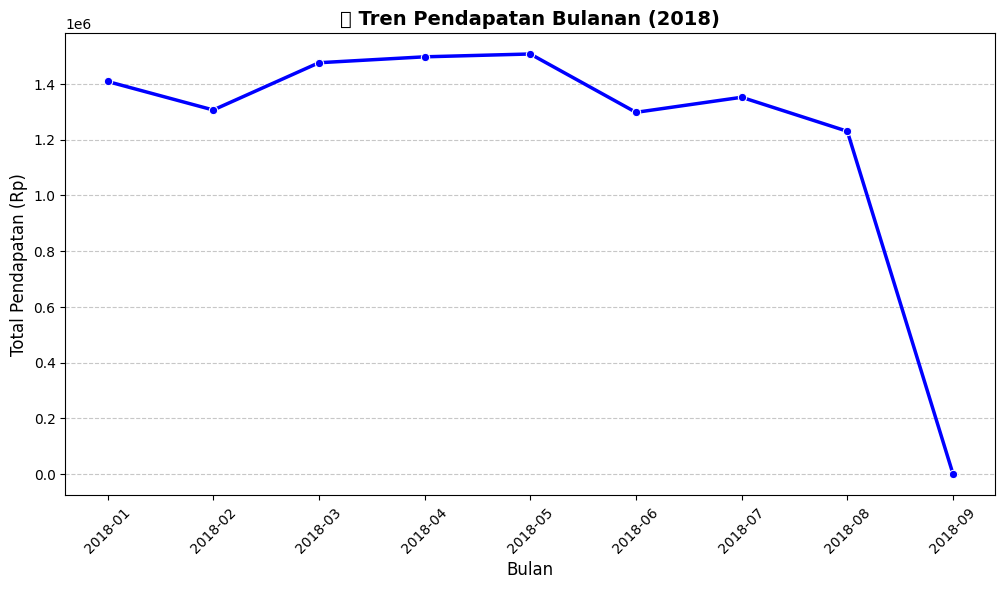

C:\Users\yogas\AppData\Local\Temp\ipykernel_7796\1379751475.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=monthly_revenue.index.astype(str),
C:\Users\yogas\anaconda3\envs\Skripsi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


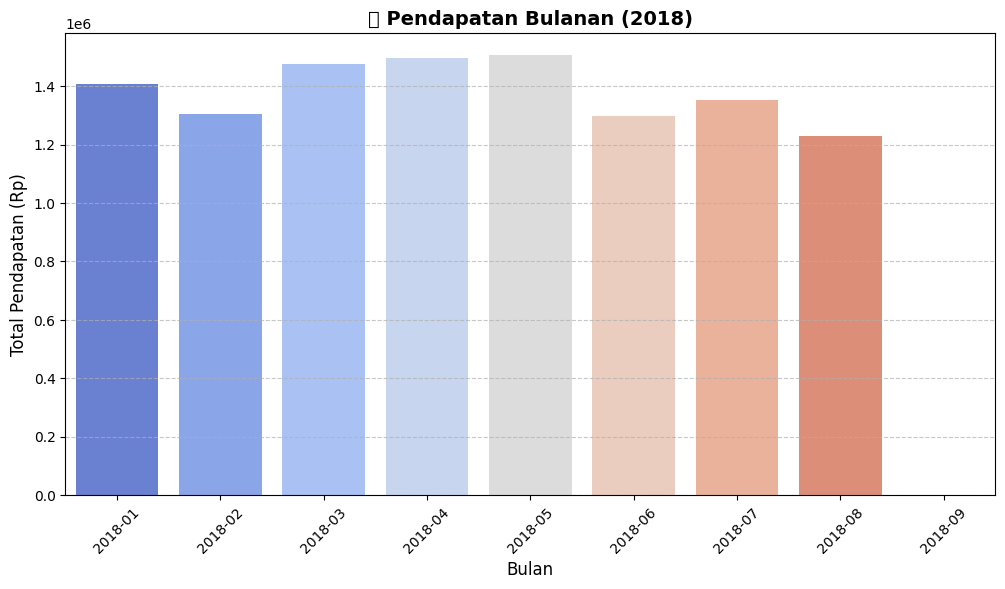

C:\Users\yogas\anaconda3\envs\Skripsi\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


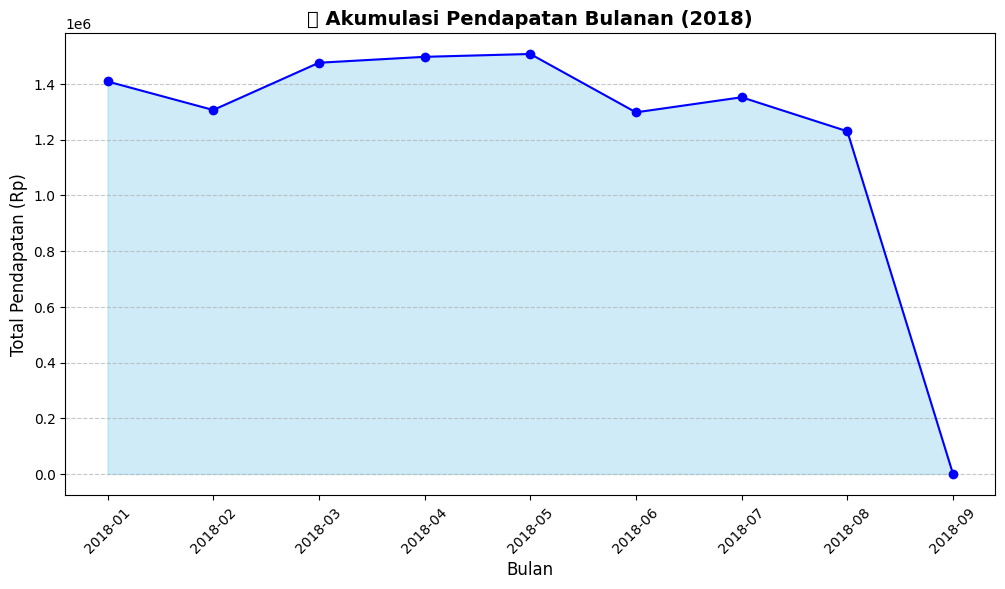


📅 Bulan dengan pendapatan tertinggi: 2018-05
💰 Total pendapatan tertinggi: Rp1,506,974.84


In [9]:
# === 📈 Line Chart (Grafik Garis) ===
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_revenue.index.astype(str), 
             y=monthly_revenue.values, 
             marker="o", 
             linewidth=2.5, 
             color="blue")

plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Total Pendapatan (Rp)", fontsize=12)
plt.title("📈 Tren Pendapatan Bulanan (2018)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# === 📊 Bar Chart (Grafik Batang) ===
plt.figure(figsize=(12, 6))
sns.barplot(x=monthly_revenue.index.astype(str), 
            y=monthly_revenue.values, 
            palette="coolwarm")

plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Total Pendapatan (Rp)", fontsize=12)
plt.title("💰 Pendapatan Bulanan (2018)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# === 📊 Area Chart (Grafik Area) ===
plt.figure(figsize=(12, 6))
plt.fill_between(monthly_revenue.index.astype(str), 
                 monthly_revenue.values, 
                 color="skyblue", 
                 alpha=0.4)
plt.plot(monthly_revenue.index.astype(str), 
         monthly_revenue.values, 
         marker="o", 
         color="blue")

plt.xlabel("Bulan", fontsize=12)
plt.ylabel("Total Pendapatan (Rp)", fontsize=12)
plt.title("📊 Akumulasi Pendapatan Bulanan (2018)", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# === 🏆 Menampilkan Bulan dengan Pendapatan Tertinggi ===
print(f"\n📅 Bulan dengan pendapatan tertinggi: {highest_revenue_month}")
print(f"💰 Total pendapatan tertinggi: Rp{highest_revenue_value:,.2f}")


**Insight:**
- Pendapatan tertinggi terjadi di bulan tertentu → Mungkin berkaitan dengan hari libur atau event khusus.
- Metode pembayaran bervariasi berdasarkan jumlah transaksi → Bisa digunakan untuk optimasi metode pembayaran yang lebih efisien.

## Analisis Lanjutan (Opsional)

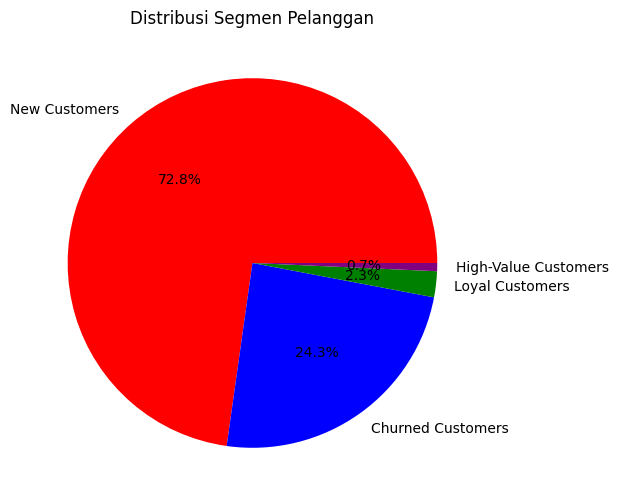

                        customer_id  total_orders  total_spent  \
0  00012a2ce6f8dcda20d059ce98491703             1       114.74   
1  000161a058600d5901f007fab4c27140             1        67.41   
2  0001fd6190edaaf884bcaf3d49edf079             1       195.42   
3  0002414f95344307404f0ace7a26f1d5             1       179.35   
4  000379cdec625522490c315e70c7a9fb             1       107.01   

  customer_segment  
0    New Customers  
1    New Customers  
2    New Customers  
3    New Customers  
4    New Customers  


In [10]:
# === 1. Load Data dengan os ===
# Tentukan lokasi folder dataset di Windows
data_dir = r"C:\Users\yogas\submission\data" 

# Mendeteksi file dalam direktori kerja
orders_file = os.path.join(data_dir, "orders_dataset.csv")
payments_file = os.path.join(data_dir, "order_payments_dataset.csv")

# Membaca dataset
orders = pd.read_csv(orders_file, parse_dates=["order_purchase_timestamp"])
payments = pd.read_csv(payments_file)

# === 2. Data Preparation ===
# Menggabungkan data orders dengan payments untuk mendapatkan total pembayaran per pelanggan
customer_data = orders.merge(payments, on="order_id")

# Mengelompokkan data berdasarkan customer_id untuk menghitung jumlah pesanan dan total pembayaran
customer_summary = customer_data.groupby("customer_id").agg(
    total_orders=("order_id", "count"),
    total_spent=("payment_value", "sum")
).reset_index()

# === 3. Clustering Berdasarkan Kuantil ===
# Menentukan kuantil untuk segmentasi pelanggan
q1_orders = customer_summary["total_orders"].quantile(0.25)
q3_orders = customer_summary["total_orders"].quantile(0.75)

q1_spent = customer_summary["total_spent"].quantile(0.25)
q3_spent = customer_summary["total_spent"].quantile(0.75)

# Fungsi untuk menetapkan segmentasi pelanggan
def assign_cluster(row):
    if row["total_orders"] <= q1_orders and row["total_spent"] <= q1_spent:
        return "Churned Customers"
    elif row["total_orders"] <= q1_orders and row["total_spent"] > q1_spent:
        return "New Customers"
    elif row["total_orders"] > q1_orders and row["total_spent"] <= q3_spent:
        return "Loyal Customers"
    else:
        return "High-Value Customers"

# Menerapkan fungsi ke data
customer_summary["customer_segment"] = customer_summary.apply(assign_cluster, axis=1)

# === 4. Visualisasi Distribusi Segmen Pelanggan ===
segment_counts = customer_summary["customer_segment"].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(segment_counts, labels=segment_counts.index, autopct="%1.1f%%", colors=["red", "blue", "green", "purple"])
plt.title("Distribusi Segmen Pelanggan")
plt.show()

# Menampilkan beberapa data pertama dari hasil clustering
print(customer_summary.head())


## Conclusion

- Metode pembayaran yang paling banyak digunakan adalah kartu kredit dan transfer bank, yang menunjukkan bahwa pelanggan lebih memilih transaksi digital dibandingkan metode pembayaran lain seperti boleto atau voucher.
- Pelanggan dapat dikelompokkan berdasarkan pola pembelian mereka, tanpa menggunakan algoritma machine learning.